# CNN for one subject

In [1]:
%pylab
%matplotlib inline

import glob
import os

CORPORA_PATH = "~/projects/corpora/P3Speller/P3Speller-old-y-datos/sets/"

file_path = os.path.expanduser(CORPORA_PATH)
files = glob.glob(os.path.join(file_path, "*.set"))


filename = files[109]

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import mne
data_mne = mne.io.read_raw_eeglab(
    filename, preload=True, event_id={"0": 1, "1": 2})

data_mne.filter(0, 20)

Reading /home/jmperez/projects/corpora/P3Speller/P3Speller-old-y-datos/sets/PruebasMuseo_30261001.fdt
Reading 0 ... 94591  =      0.000 ...   738.992 secs...
Setting up low-pass filter at 20 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 169 samples (1.320 sec) selected


<RawEEGLAB  |  PruebasMuseo_30261001.fdt, n_channels x n_times : 15 x 94592 (739.0 sec), ~10.9 MB, data loaded>

In [3]:
events = mne.find_events(data_mne)

2700 events found
Events id: [1 2]


In [4]:
epochs = mne.Epochs(
        data_mne, events,
        baseline=(None, 0), tmin=-0.1, tmax=0.7)

epochs.load_data()

2700 matching events found
0 projection items activated
Loading data for 2700 events and 104 original time points ...
0 bad epochs dropped


<Epochs  |  n_events : 2700 (all good), tmin : -0.1015625 (s), tmax : 0.703125 (s), baseline : (None, 0), ~32.2 MB, data loaded,
 '1': 2250, '2': 450>

Targets appear as 2 in the third column


We remove last channel as well

In [5]:
import sklearn.utils

X = epochs.get_data()[:, :-1]
y = (events[:, 2] == 2).astype('float')

def normalize(X):
    mean = X.mean(axis=(0, 2)).reshape(-1, 1)
    std = X.std(axis=(0, 2)).reshape(-1, 1)
    return (X - mean) / std

X = normalize(X)

We need to balance date, first of all

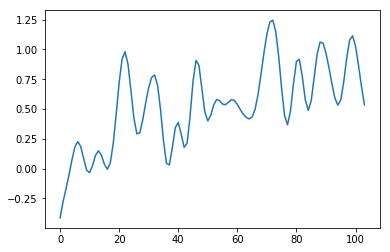

In [6]:
plot(X[0][1]);

In [7]:
n = y.shape[0]

print("Balance Class 0 : {} Class 1 {}".format(sum(y == 0)/n, sum(y==1) / n))

Balance Class 0 : 0.8333333333333334 Class 1 0.16666666666666666


In [8]:
X.shape, y.shape

((2700, 14, 104), (2700,))

In [65]:
from sklearn.model_selection import train_test_split

train_test_split?
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.1, stratify=y)

# Simple MLP 

In [121]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool2D, Flatten, Dense, Dropout


model = Sequential()

input_shape = X.shape[1:]

#n_kernels = 100
#model.add(Conv1D(n_kernels, 10, 
#                activation='sigmoid', input_shape=(14, 104)))
model.add(Flatten(input_shape=(14, 104)))
model.add(Dropout(0.55))
model.add(Dense(4096, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', # using the cross-entropy loss function
              optimizer='adam', 
              metrics=['accuracy']) # reporting the accuracy

In [122]:
model.fit(X_train, y_train, epochs=40, batch_size=64, class_weight={0:1, 1:6})

Epoch 1/40
2430/2430 [==============================] - 4s 2ms/step - loss: 0.7753 - acc: 0.4514
Epoch 2/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.7540 - acc: 0.5037
Epoch 3/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.7607 - acc: 0.4490
Epoch 4/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.7402 - acc: 0.4510
Epoch 5/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.7195 - acc: 0.4156
Epoch 6/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.6566 - acc: 0.5128
Epoch 7/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.6599 - acc: 0.4872
Epoch 8/40
2430/2430 [==============================] - 4s 2ms/step - loss: 0.6267 - acc: 0.5160
Epoch 9/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.5446 - acc: 0.5210
Epoch 10/40
2430/2430 [==============================] - 4s 1ms/step - loss: 0.4878 - acc: 0.5272
Epoch 11/40
2430/2430 [======

In [123]:
model.evaluate(X_test, y_test, verbose=1)


270/270 [==============================] - 0s 785us/step


[0.212143874168396, 0.71481481437329897]

In [124]:
y_pred = model.predict_classes(X_test)
y_prob = model.predict(X_test)
#np.hstack((y_prob, y_pred, y_test.reshape(-1, 1)))

In [125]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

print("""
Accuracy   = {}
Precision  = {}
Recall     = {}
ROC AUC    = {}
""".format(accuracy, precision, recall, auc))


Accuracy   = 0.7148148148148148
Precision  = 0.15217391304347827
Recall     = 0.15555555555555556
ROC AUC    = 0.4933333333333333



Accuracy   = 0.5555555555555556
Precision  = 0.1559633027522936
Recall     = 0.37777777777777777
ROC AUC    = 0.49086419753086424

# CNN

In [ ]:

model = Sequential()

input_shape = X.shape[1:]

#n_kernels = 100
#model.add(Conv1D(n_kernels, 10, 
#                activation='sigmoid', input_shape=(14, 104)))
model.add(Flatten(input_shape=(14, 104)))
model.add(Dropout(0.25))
model.add(Dense(1024))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
              optimizer='rmsprop', 
              metrics=['accuracy']) # reporting the accuracy